In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook',
        style='whitegrid',
        palette='deep',
        font='sans-serif',
        font_scale=1,
        color_codes=True,
        rc=None)


from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import datetime, os
from keras.preprocessing.sequence import TimeseriesGenerator

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_data = pd.read_csv('/content/drive/MyDrive/train_2.csv')
train = train_data
train.head(3)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0


In [3]:
train = train.fillna(method='ffill', downcast='infer')
train.tail(3)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,3,10,0,2,2,0,7,45,1,19,12,14,7,4,0,0,1,0,0,0,1,0,1,1,1,0,0,1,0,0,1,0,0,11,4,19,2,3,0,...,6,11,9,10,11,13,7,8,13,8,14,4,10,8,8,13,14,7,5,9,9,16,10,12,10,13,10,21,11,9,11,25,22,47,42,13,9,21,16,6
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,3,10,0,2,2,0,7,45,1,19,12,14,7,4,0,0,1,0,0,0,1,0,1,1,1,0,0,1,0,0,1,0,0,11,4,19,2,3,0,...,6,17,3,4,5,1,4,2,12,3,1,3,4,1,3,4,0,5,8,0,1,10,10,11,3,10,5,3,9,2,4,6,5,1,5,8,2,4,3,3
145062,Francisco_el_matemático_(serie_de_televisión_d...,3,10,0,2,2,0,7,45,1,19,12,14,7,4,0,0,1,0,0,0,1,0,1,1,1,0,0,1,0,0,1,0,0,11,4,19,2,3,0,...,6,7,6,5,2,3,5,3,5,1,2,3,4,1,2,2,5,2,3,4,1,9,5,8,5,8,11,9,6,5,2,29,6,5,2,2,7,6,10,3


In [4]:
for cols in train.columns[1:]:
    train[cols] = pd.to_numeric(train[cols], downcast='integer')

In [5]:
df = pd.DataFrame(train.iloc[:,1:].values.T,
            columns=train.Page.values, index=train.columns[1:])
df.index = pd.to_datetime(df.index, errors='ignore',
                                            dayfirst=False,
                                            yearfirst=False,
                                            utc=None,
                                            format="%Y/%m/%d",
                                            exact=False,
                                            unit=None,
                                            infer_datetime_format=True,
                                            origin='unix',
                                            cache=True)
df.head(3)

,2NE1_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access_spider,3C_zh.wikipedia.org_all-access_spider,4minute_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,5566_zh.wikipedia.org_all-access_spider,91Days_zh.wikipedia.org_all-access_spider,A'N'D_zh.wikipedia.org_all-access_spider,AKB48_zh.wikipedia.org_all-access_spider,ASCII_zh.wikipedia.org_all-access_spider,ASTRO_zh.wikipedia.org_all-access_spider,Ahq_e-Sports_Club_zh.wikipedia.org_all-access_spider,All_your_base_are_belong_to_us_zh.wikipedia.org_all-access_spider,AlphaGo_zh.wikipedia.org_all-access_spider,Android_zh.wikipedia.org_all-access_spider,Angelababy_zh.wikipedia.org_all-access_spider,Apink_zh.wikipedia.org_all-access_spider,Apple_II_zh.wikipedia.org_all-access_spider,As_One_zh.wikipedia.org_all-access_spider,B-PROJECT_zh.wikipedia.org_all-access_spider,B1A4_zh.wikipedia.org_all-access_spider,BDSM_zh.wikipedia.org_all-access_spider,BEAST_zh.wikipedia.org_all-access_spider,BIGBANG_zh.wikipedia.org_all-access_spider,BLACK_PINK_zh.wikipedia.org_all-access_spider,BLEACH_zh.wikipedia.org_all-access_spider,BTOB_zh.wikipedia.org_all-access_spider,Beautiful_Mind_zh.wikipedia.org_all-access_spider,Beyond_zh.wikipedia.org_all-access_spider,Big_zh.wikipedia.org_all-access_spider,Block_B_zh.wikipedia.org_all-access_spider,CHAOS;CHILD_zh.wikipedia.org_all-access_spider,CHAOS;HEAD_zh.wikipedia.org_all-access_spider,CLC_zh.wikipedia.org_all-access_spider,CNBLUE_zh.wikipedia.org_all-access_spider,DIA_zh.wikipedia.org_all-access_spider,Daigo_zh.wikipedia.org_all-access_spider,Dear_My_Friends_zh.wikipedia.org_all-access_spider,Doctors_zh.wikipedia.org_all-access_spider,EGOIST_zh.wikipedia.org_all-access_spider,...,La_niña_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Capitán_América:_Civil_war_es.wikipedia.org_all-access_spider,Wikipedia:Wikiconcurso/Desafíos_de_edición_WMAR_Mayo_2016_es.wikipedia.org_all-access_spider,Región_andina_(Colombia)_es.wikipedia.org_all-access_spider,Anexo:Medallero_histórico_de_los_Juegos_Olímpicos_es.wikipedia.org_all-access_spider,Chavín_(cultura)_es.wikipedia.org_all-access_spider,Winifer_Fernández_es.wikipedia.org_all-access_spider,Cazafantasmas_(película_de_2016)_es.wikipedia.org_all-access_spider,Anexo:Tenis_en_los_Juegos_Olímpicos_de_Río_de_Janeiro_2016_es.wikipedia.org_all-access_spider,Un_monstruo_viene_a_verme_(película)_es.wikipedia.org_all-access_spider,Sin_senos_sí_hay_paraíso_es.wikipedia.org_all-access_spider,Anexo:Medallero_de_los_Juegos_Olímpicos_de_Río_de_Janeiro_2016_es.wikipedia.org_all-access_spider,Arrival_(película)_es.wikipedia.org_all-access_spider,Anexo:Baloncesto_en_los_Juegos_Olímpicos_de_Río_de_Janeiro_2016_es.wikipedia.org_all-access_spider,Hasta_que_te_conocí_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Westworld_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Milénico_es.wikipedia.org_all-access_spider,Moonlight_(película)_es.wikipedia.org_all-access_spider,Sully_(película)_es.wikipedia.org_all-access_spider,Pulsaciones_(serie_de_televisión)_es.wikipedia.org_all-access_spider,2091_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Campeonato_Sudamericano_de_Fútbol_Sub-20_de_2017_es.wikipedia.org_all-access_spider,Split_(película)_es.wikipedia.org_all-access_spider,Huracán_Matthew_es.wikipedia.org_all-access_spider,Fences_(película)_es.wikipedia.org_all-access_spider,Logan_(película)_es.wikipedia.org_all-access_spider,La_doña_(telenovela_de_2016)_es.wikipedia.org_all-access_spider,RTS_(canal_de_televisión)_es.wikipedia.org_all-access_spider,La_ley_del_corazón_es.wikipedia.org_all-access_spider,The_Crown_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Drake_(músico)_es.wikipedia.org_all-access_spider,Skam_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Legión_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Doble_tentación_es.wikipedia.org_all-access_spider,Mi_adorable_maldición_es.wikipedia.org_all-access_s

Without Language

In [8]:
#import random
#random.seed(10)
#sample_list = [random.randint(0,df.shape[1]) for _ in range(100)]

In [36]:
hits = df.iloc[:,:100]

In [37]:
hits.shape

(803, 100)

In [38]:
brk = 0.7
data_split = int(len(hits)*brk)
data_split
X, y = hits.iloc[:data_split,:], hits.iloc[data_split:,:]

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)

scaled_X = scaler.transform(X)
scaled_y = scaler.transform(y)

In [40]:
length = 7
batch = 1

n_features = scaled_X.shape[1]
n_features

100

In [41]:
generator = TimeseriesGenerator(data = scaled_X,targets = scaled_X, 
                                length = length, 
                                sampling_rate=1,
                                stride=1,
                                start_index=0,
                                end_index=None,
                                shuffle=False,
                                reverse=False,
                                batch_size=batch)

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

model=Sequential(layers=None,name="LSTM_Model")
model.add(LSTM(units=400,input_shape=(length,n_features),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=500,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(100,activation="relu"))
model.add(Dense(units=n_features)) 
model.compile(optimizer='adam',loss='mean_squared_error')

In [43]:
model.fit(generator,batch_size=10,epochs=10)

Epoch 1/10
555/555 [==============================] - 46s 75ms/step - loss: 0.0096
Epoch 2/10
555/555 [==============================] - 41s 74ms/step - loss: 0.0081
Epoch 3/10
555/555 [==============================] - 41s 74ms/step - loss: 0.0080
Epoch 4/10
555/555 [==============================] - 41s 74ms/step - loss: 0.0074
Epoch 5/10
555/555 [==============================] - 42s 75ms/step - loss: 0.0073
Epoch 6/10
555/555 [==============================] - 41s 75ms/step - loss: 0.0075
Epoch 7/10
555/555 [==============================] - 41s 74ms/step - loss: 0.0075
Epoch 8/10
555/555 [==============================] - 40s 73ms/step - loss: 0.0070
Epoch 9/10
555/555 [==============================] - 41s 75ms/step - loss: 0.0075
Epoch 10/10
555/555 [==============================] - 42s 75ms/step - loss: 0.0068


In [55]:
test_predictions = []

first_eval_batch = scaled_X[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_y)):
    current_pred = model.predict(current_batch,verbose=0)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [56]:
y_pred=scaler.inverse_transform(test_predictions)

In [57]:
from sklearn import metrics
a = metrics.mean_squared_error(y_pred, y)** 0.5
from numpy import * 
mean(a)

35.46513024528469

In [58]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''

    diff = np.abs((y_true - y_pred)/
                np.clip(np.abs(y_true) + np.abs(y_pred), np.float32(1e-07), None))
    return np.float32(200.) * np.nanmean(diff, axis=axis)

In [59]:
smape(y_pred, y)

63.68115781184771

In [62]:
y_pred

array([[14.26158487, 34.25315541,  5.65222878, ...,  0.11063078,
        12.36738583, 17.41933852],
       [14.87550209, 35.8370396 ,  4.70896985, ..., -1.00105226,
        12.42266601, 16.32942475],
       [16.52521983, 35.61077932,  4.79056645, ...,  0.22843053,
        13.29576449, 15.72398603],
       ...,
       [22.22304484, 26.48125564,  6.15200266, ...,  4.10600097,
        15.01332874, 15.01854137],
       [22.22304484, 26.48125564,  6.15200266, ...,  4.10600097,
        15.01332958, 15.01854137],
       [22.22304484, 26.48125564,  6.15200266, ...,  4.10600097,
        15.01332874, 15.01854137]])

With Language

In [70]:
wikipedia = (df.filter(like='wikipedia'))
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'other'


(train.columns.map(get_language)).unique()

languages = list((wikipedia.columns.map(get_language)).unique())
languages.remove('other')

for lang in (languages):
    locals()['lang_'+str(lang)] = wikipedia.loc[:, wikipedia.columns.str.contains('_'+str(lang)+'.wiki')]
for lang in (languages):
    locals()['hits_'+str(lang)] = np.array(locals()['lang_'+str(lang)].iloc[:,:].mean(axis=1))

In [71]:
keys = languages
values = ['Chinese', 'French', 'English', 'Russian', 'German', 'Japanese', 'Spanish']
d = dict(zip(keys,values))

index = wikipedia.index

hits = pd.DataFrame(index=index, columns=list(d.values()))
hits = hits.fillna(0)

In [72]:
for key, value in d.items():
    hits[value] = locals()['hits_'+str(key)]

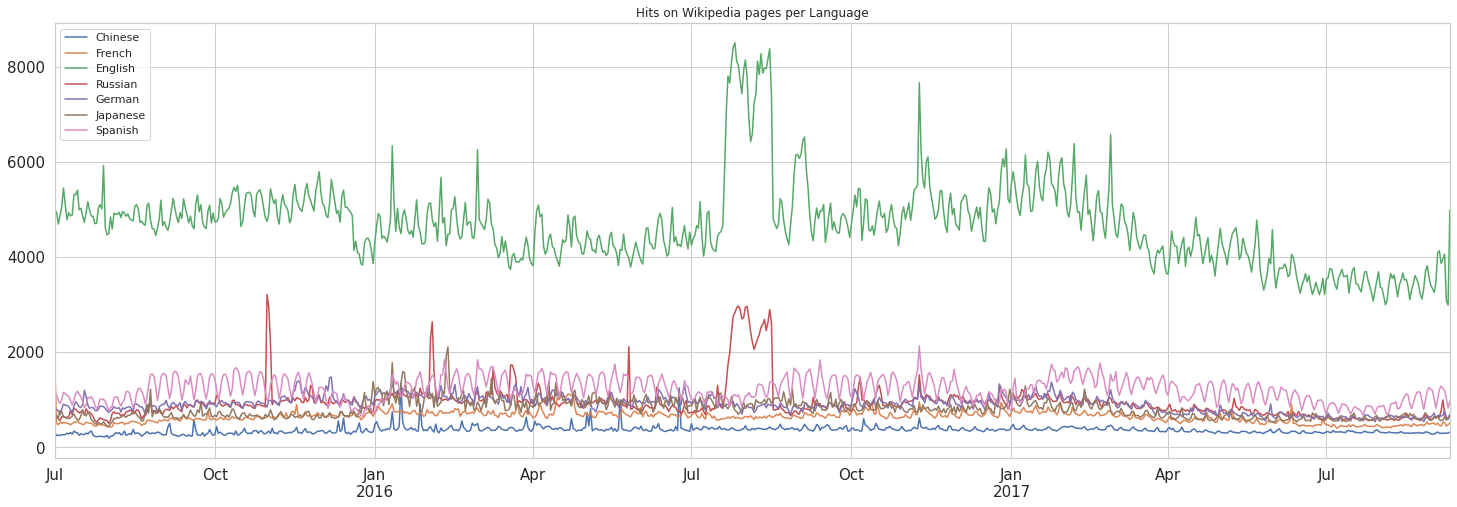

In [73]:
hits.plot(figsize=(25,8), title ='Hits on Wikipedia pages per Language', fontsize=15)
plt.legend(loc='upper left')
plt.show()

In [75]:
brk = 0.7
data_split = int(len(hits)*brk)
data_split
X, y = hits.iloc[:data_split,:], hits.iloc[data_split:,:]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)

scaled_X = scaler.transform(X)
scaled_y = scaler.transform(y)

length = 7
batch = 1

n_features = scaled_X.shape[1]
n_features

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout


model = Sequential(layers=None, name="LSTM_Model")

model.add(LSTM(units=400 ,input_shape=(length, n_features),return_sequences = True) )
model.add(Dropout(0.2))
model.add(LSTM(units = 500, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(100, activation="relu"))
model.add(Dense(units = n_features)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
model.fit(generator, batch_size = 10, epochs = 10)

In [ ]:
test_predictions = []

first_eval_batch = scaled_X[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_y)):
    current_pred = model.predict(current_batch,verbose=0)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
y_pred=scaler.inverse_transform(test_predictions)

In [ ]:
from sklearn import metrics
a = metrics.mean_squared_error(y_pred, y)** 0.5
from numpy import * 
mean(a)

In [ ]:
smape(y_pred, y)